# WGAN-GP for EEG signals

## Wasserstein GAN (WGAN) with Gradient Penalty (GP)



## Imports


In [ ]:
import numpy as np
import pickle as pickle
import pandas as pd
from scipy.stats import skew,kurtosis
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model,layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,RepeatedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate,cross_val_score


import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("..")


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# A = np.load('/content/drive/MyDrive/Thesis data/A.npy') # File with all(40) channel data
# B = np.load('/content/drive/MyDrive/Thesis data/B.npy') #File with only data from left hemisphere 
A_norm = np.load('/content/drive/MyDrive/Thesis data/traindata.npy') # normalised 40 channel data of only 22 parts
B_norm = np.load('/content/drive/MyDrive/Thesis data/Anorm.npy') # normalised 7 channel data
A_norm = A_norm.reshape(-1,40,99)
print("trainingdata.shape =",A_norm.shape)
# print("B.shape =",B_norm.shape)
#Load the labels now    
valence = np.genfromtxt('/content/drive/MyDrive/Thesis data/label_class_0.dat', delimiter=' ')
arousal = np.genfromtxt('/content/drive/MyDrive/Thesis data/label_class_1.dat', delimiter=' ')
dominance = np.genfromtxt('/content/drive/MyDrive/Thesis data/label_class_2.dat', delimiter=' ')
liking = np.genfromtxt('/content/drive/MyDrive/Thesis data/label_class_3.dat', delimiter=' ')


trainingdata.shape = (880, 40, 99)


## SPLIT DATA INTO TEST AND TRAINING


Use ONLY TRAINING DATA to train the GAN, run these lines only when needed for the first time.

In [ ]:
# testsize=0.3125 # 880 train data points and 440 test data points

In [ ]:
# # valence
# xtrain, xtest, ytrain, ytest = train_test_split(A_norm, valence, test_size=testsize ,shuffle = True,random_state = 100)
# ytrain.shape
# np.save("/content/drive/MyDrive/Thesis data/val22",ytrain)
# np.save("/content/drive/MyDrive/Thesis data/val10",ytest)

In [ ]:
# # arousal
# xtrain, xtest, ytrain, ytest = train_test_split(A_norm, arousal, test_size=testsize ,shuffle = True,random_state = 100)
# ytrain.shape
# np.save("/content/drive/MyDrive/Thesis data/aro22",ytrain)
# np.save("/content/drive/MyDrive/Thesis data/aro10",ytest)

In [ ]:
# # dominance
# xtrain, xtest, ytrain, ytest = train_test_split(A_norm, dominance, test_size=testsize ,shuffle = True,random_state = 100)
# ytrain.shape
# np.save("/content/drive/MyDrive/Thesis data/dom22",ytrain)
# np.save("/content/drive/MyDrive/Thesis data/dom10",ytest)

In [ ]:
# # liking
# xtrain, xtest, ytrain, ytest = train_test_split(A_norm, liking, test_size=testsize ,shuffle = True,random_state = 100)
# ytrain.shape
# np.save("/content/drive/MyDrive/Thesis data/lik22",ytrain)
# np.save("/content/drive/MyDrive/Thesis data/lik10",ytest)

## Data preparation

To train WGAN-GP I would be using EEG dataset of extracted features. Each
sample in this dataset is a 40*99 matrix of features associated with a label

In [ ]:
IMG_SHAPE = (40, 99, 1)
BATCH_SIZE = 40 #32

# Size of the noise vector
noise_dim = 256 # also tried 128
train_images = A_norm.reshape(-1,40,99,1) # Add extra dimension to the dataset


print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")


train_images.shape


Number of examples: 880
Shape of the images in the dataset: (40, 99, 1)


(880, 40, 99, 1)

## Create the critic (simply called the discriminator in the original GAN variant)

The samples in the dataset have a (40, 99, 1) shape for each input image.

I define a convolutional blocks function that takes in various parameters like the number of filters,activation,batch normalization and dropouts.

In general the strides chosen for the Conv2D layers are of stride 2 this shrinks the image size by half each time

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 99, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 44, 103, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 52, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 22, 52, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 26, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 26, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 26, 128)     

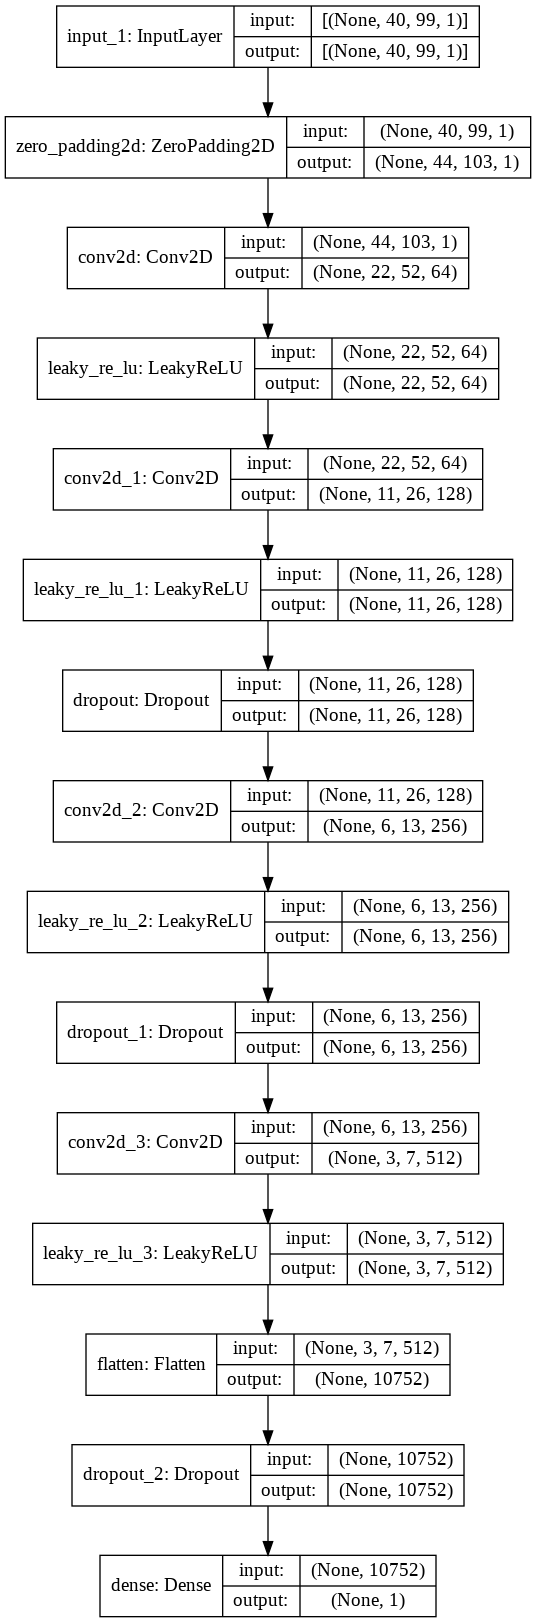

In [ ]:

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
  
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()
plot_model(d_model,show_shapes=True)


## Create the generator


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 14080)             3604480   
_________________________________________________________________
batch_normalization (BatchNo (None, 14080)             56320     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14080)             0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 11, 256)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 33, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 33, 128)       29

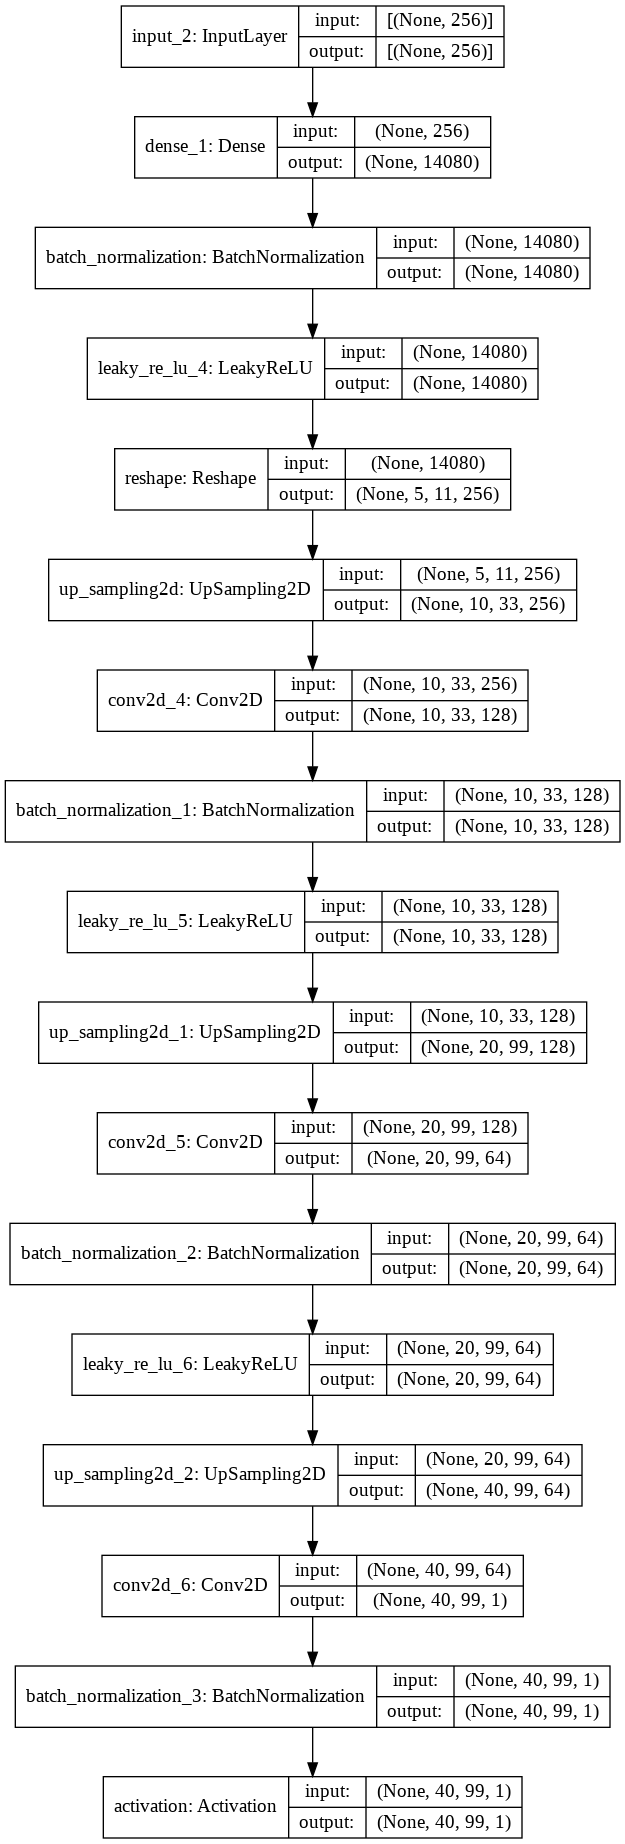

In [ ]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(5 * 11 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((5, 11, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
        up_size=(2, 3)
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
        up_size=(2, 3)
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True,up_size=(2, 1)
    )
    
    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()
plot_model(g_model,show_shapes=True)


## Create the WGAN-GP model
The generator and discriminator functions are ready, I use this to create WGAN-GP model. We will also override the `train_step` for training.

In [ ]:
class WGAN(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        n_critic=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = n_critic
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        diff = fake_images - real_images
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)  # Each image in the batch gets a random number between 0 and 1 
        interpolated = real_images + alpha * diff # can also use : alpha*real + (1-alpha)*fake

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2) # or do 1-gradient norm
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # According to the original paper the following steps are computed for each of the batch:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Discriminator is trained first 
        # Generally the critic is trained 'x' times more than 1 step of the generator .The original WGAN recommends this value be 5.
        # n_critic = 5 means that the critic is trained 5 times before updating the weights of the generator.
        
        for i in range(self.d_steps): 
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

## Create a callback that saves the generated data into the folder specified

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=880, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        # print((self.num_img))
        arr = np.zeros((880,40,99))
        for i in range(self.num_img):
            img = generated_images[i].numpy()

            arr[i] = img.reshape(40,99)
            
            # print(generated_images[i].shape)
            # print("img shape",img.shape)
            # '/content/drive/MyDrive/Thesis data/
        np.save("/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep{epoch}".format(epoch=epoch+1),arr) #changed the location


## Train the end-to-end model


In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 100

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=880, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    n_critic=5,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/100
22/22 [==============================] - 23s 472ms/step - d_loss: -59.3318 - g_loss: 92.2454
Epoch 2/100
22/22 [==============================] - 11s 479ms/step - d_loss: -49.8452 - g_loss: 70.9916
Epoch 3/100
22/22 [==============================] - 11s 486ms/step - d_loss: -40.9213 - g_loss: 35.8706
Epoch 4/100
22/22 [==============================] - 11s 493ms/step - d_loss: -37.2276 - g_loss: 12.6573
Epoch 5/100
22/22 [==============================] - 11s 499ms/step - d_loss: -34.4972 - g_loss: 5.1851
Epoch 6/100
22/22 [==============================] - 11s 508ms/step - d_loss: -31.6208 - g_loss: 3.4819
Epoch 7/100
22/22 [==============================] - 11s 514ms/step - d_loss: -29.8439 - g_loss: 1.6318
Epoch 8/100
22/22 [==============================] - 11s 522ms/step - d_loss: -28.5610 - g_loss: -3.1172
Epoch 9/100
22/22 [==============================] - 12s 530ms/step - d_loss: -27.4989 - g_loss: -5.5705
Epoch 10/100
22/22 [==============================] - 12s 

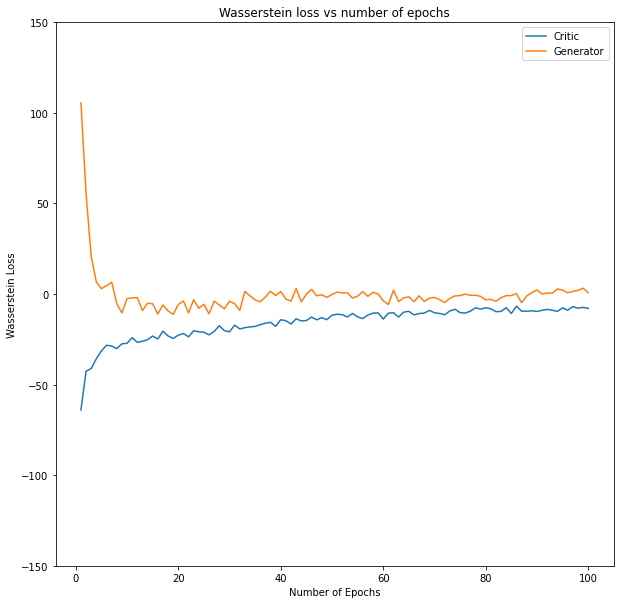

In [ ]:
import matplotlib.pyplot as plt
i = [x for  x in range(1,101)]
fig = plt.figure(figsize=(10,10))
plt.ylim(-150, 150)
p1 = plt.plot(i,wgan.history.history['d_loss']) # critic loss
p2 = plt.plot(i,wgan.history.history['g_loss']) # generator loss

plt.ylabel('Wasserstein Loss')
plt.title('Wasserstein loss vs number of epochs')
plt.xlabel('Number of Epochs')
plt.legend((p1[0], p2[0]), ('Critic', 'Generator'))

choose the epoch data with losses close to zero <br> From careful inspection I would choose the data from epochs 89, 91, 97, 100 <br>
stored in the location
'/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep{epoch}'






Epoch 89/100
22/22 [==============================] - 12s 523ms/step - d_loss: -8.3176 - g_loss: -0.0374

Epoch 91/100
22/22 [==============================] - 12s 523ms/step - d_loss: -8.1211 - g_loss: 0.1259

Epoch 97/100
22/22 [==============================] - 12s 523ms/step - d_loss: -7.7755 - g_loss: 1.1294

Epoch 100/100
22/22 [==============================] - 12s 525ms/step - d_loss: -8.0064 - g_loss: 0.4637

In [ ]:
tttttttttttt =np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep78.npy') # just testing
tttttttttttt.shape

(880, 40, 99)

<!-- np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep89.npy')
np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep91.npy')
np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep97.npy')
np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep100.npy') -->

In [ ]:
## This is the data location of the files.
# np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep89.npy')
# np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep91.npy')
# np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep97.npy')
# np.load('/content/drive/MyDrive/Thesis data/3rdGAN/Generated_ep100.npy')